In [1]:
import torch
import torch.nn as nn
import torchvision 
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import tqdm as notebook_tqdm
import numpy as np
import matplotlib.pyplot as plt

C:\Users\bruno\anaconda3\envs\gpu\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((150,150))
                               ])

train = torchvision.datasets.ImageFolder(root = '../../dataset/train',
                                           transform = transform)

test = torchvision.datasets.ImageFolder(root = '../../dataset/test',
                                           transform = transform)

print("No of Classes: train ", len(train.classes))
print("No of Classes: test ", len(test.classes))

No of Classes: train  2
No of Classes: test  2


In [4]:
train_set_size = int(len(train) * 0.8) + 1
valid_set_size = len(train) - train_set_size 

train_set, val_set = torch.utils.data.random_split(train, [train_set_size, valid_set_size])

print('Train data set:', len(train_set))
print('Test data set:', len(val_set))

Train data set: 2202
Test data set: 550


In [5]:
train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                           batch_size = 32, 
                                           shuffle = True)

val_loader = torch.utils.data.DataLoader(dataset = val_set,
                                         batch_size = 32, 
                                         shuffle = False)

test_loader = torch.utils.data.DataLoader(dataset = test,
                                         batch_size = 32, 
                                         shuffle = False)

In [6]:
squeezenet = torchvision.models.squeezenet1_1(pretrained=True)

def append_dropout(model, rate=0.05):
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            append_dropout(module)
        if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=False))
            setattr(model, name, new)


append_dropout(squeezenet)
print(squeezenet)



SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): Sequential(
      (0): ReLU(inplace=True)
      (1): Dropout2d(p=0.05, inplace=False)
    )
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): Sequential(
        (0): ReLU(inplace=True)
        (1): Dropout2d(p=0.05, inplace=False)
      )
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): Sequential(
        (0): ReLU(inplace=True)
        (1): Dropout2d(p=0.05, inplace=False)
      )
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): Sequential(
        (0): ReLU(inplace=True)
        (1): Dropout2d(p=0.05, inplace=False)
      )
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeez

C:\Users\bruno\anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\bruno\anaconda3\envs\gpu\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
squeezenet

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): Sequential(
      (0): ReLU(inplace=True)
      (1): Dropout2d(p=0.05, inplace=False)
    )
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): Sequential(
        (0): ReLU(inplace=True)
        (1): Dropout2d(p=0.05, inplace=False)
      )
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): Sequential(
        (0): ReLU(inplace=True)
        (1): Dropout2d(p=0.05, inplace=False)
      )
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): Sequential(
        (0): ReLU(inplace=True)
        (1): Dropout2d(p=0.05, inplace=False)
      )
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeez

In [8]:
#ftr = squeezenet.fc.in_features
#squeezenet.fc = nn.Linear(ftr, 2)

squeezenet = squeezenet.cuda()

In [9]:
optimizer = torch.optim.Adamax(squeezenet.parameters(), lr=0.001)

In [10]:
total_step = len(train_loader)
Loss = []
Acc = []
Val_Loss = []
Val_Acc = []
n=60

criterion = nn.CrossEntropyLoss()

for epoch in range(n):
    acc = 0
    val_acc = 0
    for i, (images, labels) in enumerate(train_loader):
        squeezenet.train()
        images = images.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = squeezenet(images)
        loss = criterion(outputs, labels)
    
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    acc = acc/len(train_loader.dataset) * 100
    
    for i, (images, labels) in enumerate(val_loader):
        squeezenet.eval()
        images = images.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = squeezenet(images)
        val_loss = criterion(outputs, labels)
    
        # Checking accuracy
        preds = outputs.data.max(dim=1,keepdim=True)[1]
        val_acc += preds.eq(labels.data.view_as(preds)).cpu().sum()
    
    val_acc = val_acc/len(val_loader.dataset) * 100
    
    print("Epoch {} =>  loss : {loss:.2f};   Accuracy : {acc:.2f}%;   Val_loss : {val_loss:.2f};   Val_Accuracy : {val_acc:.2f}%".format(epoch+1, loss=loss.item(), acc=acc, val_loss=val_loss.item(), val_acc=val_acc))
  
    Loss.append(loss)
    Acc.append(acc)

    Val_Loss.append(val_loss)
    Val_Acc.append(val_acc)

Epoch 1 =>  loss : 1.29;   Accuracy : 45.37%;   Val_loss : 2.18;   Val_Accuracy : 50.55%
Epoch 2 =>  loss : 0.77;   Accuracy : 51.50%;   Val_loss : 1.37;   Val_Accuracy : 67.27%
Epoch 3 =>  loss : 1.10;   Accuracy : 53.95%;   Val_loss : 1.92;   Val_Accuracy : 50.73%
Epoch 4 =>  loss : 1.10;   Accuracy : 55.59%;   Val_loss : 1.31;   Val_Accuracy : 72.91%
Epoch 5 =>  loss : 0.87;   Accuracy : 58.04%;   Val_loss : 1.48;   Val_Accuracy : 72.00%
Epoch 6 =>  loss : 0.81;   Accuracy : 62.53%;   Val_loss : 1.64;   Val_Accuracy : 80.36%
Epoch 7 =>  loss : 0.77;   Accuracy : 65.99%;   Val_loss : 1.20;   Val_Accuracy : 80.18%
Epoch 8 =>  loss : 0.92;   Accuracy : 69.85%;   Val_loss : 0.80;   Val_Accuracy : 79.45%
Epoch 9 =>  loss : 1.16;   Accuracy : 70.80%;   Val_loss : 0.92;   Val_Accuracy : 76.00%
Epoch 10 =>  loss : 0.49;   Accuracy : 71.25%;   Val_loss : 1.15;   Val_Accuracy : 80.91%
Epoch 11 =>  loss : 0.86;   Accuracy : 72.89%;   Val_loss : 0.91;   Val_Accuracy : 81.64%
Epoch 12 =>  loss :

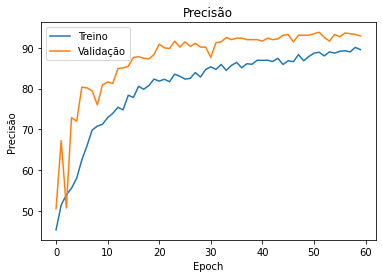

In [11]:
plt.plot(range(n),Acc)
plt.plot(range(n),Val_Acc)
plt.ylabel('Precisão')
plt.xlabel('Epoch')
plt.title("Precisão")
plt.legend(["Treino", "Validação"])
plt.show()

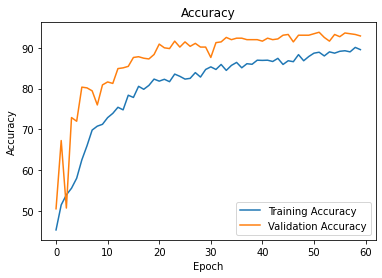

In [12]:
plt.plot(range(n),Acc)
plt.plot(range(n),Val_Acc)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.title("Accuracy")
plt.legend(["Training Accuracy", "Validation Accuracy"])
plt.show()

In [13]:
save_path = 'squeezenet.pth'
torch.save(squeezenet.state_dict(), save_path)

In [15]:
Accuracies = []
model = torchvision.models.squeezenet1_1(pretrained=True)   
#num_features = model.fc.in_features #extract fc layers features
def append_dropout(model, rate=0.05):
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            append_dropout(module)
        if isinstance(module, nn.ReLU):
            new = nn.Sequential(module, nn.Dropout2d(p=rate, inplace=False))
            setattr(model, name, new)


append_dropout(model)


#model.fc = nn.Linear(num_features, 2)#(num_of_class == 2)
model.load_state_dict(torch.load("squeezenet.pth"))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=0.001)

model.eval()  
with torch.no_grad():
    correct = 0
    total = 0

    for images, labels in test_loader:
        y_pred = []
        Images = images.to(device)
        Labels = labels.to(device)
        outputs = model(Images)
        prediction_array = outputs.data
        
        
        _, predicted = torch.max(prediction_array, 1)
        y_pred += predicted
        total += Labels.size(0)
        correct += (predicted == Labels).sum().item()
        
    acc = 100 * correct / total
    Accuracies.append(acc)
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Test Accuracy of the model on the test images: 94.62209302325581 %
